# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [87]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, countDistinct
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as psqf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer, OneHotEncoderEstimator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator


%matplotlib inline


In [88]:
# create a Spark session
spark = SparkSession.builder.getOrCreate()

In [89]:
# spark context params 
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1569459235119'),
 ('spark.driver.host', '0c1bb193dcfb'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '34571'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'pyspark-shell')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [90]:
df = spark.read.json("mini_sparkify_event_data.json")

In [91]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [92]:
print("number of rows: ", df.count())

number of rows:  286500


In [93]:
# check for blank userId and sessionId
df.select('userId').dropDuplicates().sort('userId').show(5)
df.select('sessionId').dropDuplicates().sort('sessionId').show(5)

# drop nas and blank userIds from df 
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
df = df.filter(df['userId'] != '')

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
+---------+
only showing top 5 rows



In [94]:
print("number of rows without dupe userId and sessionId and blank userId: ", df.count())

number of rows without dupe userId and sessionId and blank userId:  278154


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [95]:
df.printSchema()
# df.describe()   # similar info as above

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [96]:
# distinct counts for each variables 
for var in df.columns:
    uniques = df.select(var).dropDuplicates().count()
    print('{} has {} unique values'.format(var, uniques)) 

artist has 17656 unique values
auth has 2 unique values
firstName has 189 unique values
gender has 2 unique values
itemInSession has 1311 unique values
lastName has 173 unique values
length has 14866 unique values
level has 2 unique values
location has 114 unique values
method has 2 unique values
page has 19 unique values
registration has 225 unique values
sessionId has 2312 unique values
song has 58481 unique values
status has 3 unique values
ts has 269770 unique values
userAgent has 56 unique values
userId has 225 unique values


In [97]:
# check counts of unique values for certain fields
cols = ['auth','gender','level','page']
for var in cols: 
    df.groupBy(var).count().sort('count', ascending=False).show(30)

+---------+------+
|     auth| count|
+---------+------+
|Logged In|278102|
|Cancelled|    52|
+---------+------+

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+

+-----+------+
|level| count|
+-----+------+
| paid|222433|
| free| 55721|
+-----+------+

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



In [241]:
# check how many unique users saw cancellation confirmation and submit downgrade page 

df.groupBy(['page'])\
        .agg(countDistinct('userId'))\
        .withColumnRenamed('count(Distinct userId)', 'unique_users')\
        .where((df.page == 'Cancellation Confirmation') | (df.page == 'Submit Downgrade'))\
        .show()

+--------------------+------------+
|                page|unique_users|
+--------------------+------------+
|    Submit Downgrade|          49|
|Cancellation Conf...|          52|
+--------------------+------------+



In [242]:
# check if cancellation confirmation and submit downgrade can occur for free and paid users

df.groupBy(['level','page'])\
        .agg(countDistinct('userId'))\
        .withColumnRenamed('count(Distinct userId)', 'unique_users')\
        .where((df.page == 'Cancellation Confirmation') | (df.page == 'Submit Downgrade'))\
        .show()

+-----+--------------------+------------+
|level|                page|unique_users|
+-----+--------------------+------------+
| free|Cancellation Conf...|          21|
| paid|Cancellation Conf...|          31|
| paid|    Submit Downgrade|          49|
+-----+--------------------+------------+



In [243]:
# count number of unique users who saw cancellation confirmation and submit downgrade pages

df.where((df.page == 'Cancellation Confirmation') | (df.page == 'Submit Downgrade'))\
    .agg(countDistinct('userId'))\
    .show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                    92|
+----------------------+



### EDA findings
52/225 unique users saw the cancellation confirimation page. This page can be seen by both free and paid customers.

49/225 users saw the submit downgrade page. This can only occur for paid users. 

92/225 users saw the cancellation confirmation or submit downgrade page.

We shall proceed to a user as churned if a user has seen the cancellation confirmation page. 



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [101]:
# create cancellation function
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# apply function to create Cancellation field
df = df.withColumn("cancellation", flag_cancellation_event("page"))

# create downgraded function
flag_downgraded_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
# apply function to create Cancellation field
df = df.withColumn("downgrade", flag_downgraded_event("page"))

# create cancellation or downgraded function
flag_cancel_downgrade_event = udf(lambda x: 1 if x in ("Submit Downgrade","Cancellation Confirmation") else 0, IntegerType())
# apply function to create Cancellation field
df = df.withColumn("cancelDowngrade", flag_cancel_downgrade_event("page"))


In [102]:
# convert relevant fields to timestamp 
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn('eventTime', convert_ts('ts'))
df = df.withColumn('registrationTime', convert_ts('registration'))

In [103]:
# create and apply window function to get phase for cancellation
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("cancellationPhase", Fsum("cancellation").over(windowval))

In [104]:
# test users who saw cancellation confirmation pg 
# t = ['page','ts', 'eventTime', 'cancellation', 'cancellationPhase', 'registrationTime']
# df.select(t).where(df.userId == 125).sort('ts', ascending=False).show(10000)

+--------------------+-------------+-------------------+------------+-----------------+-------------------+
|                page|           ts|          eventTime|cancellation|cancellationPhase|   registrationTime|
+--------------------+-------------+-------------------+------------+-----------------+-------------------+
|              Cancel|1539318918000|2018-10-12 04:35:18|           0|                1|2018-08-01 20:58:59|
|Cancellation Conf...|1539318918000|2018-10-12 04:35:18|           1|                1|2018-08-01 20:58:59|
|         Roll Advert|1539318917000|2018-10-12 04:35:17|           0|                1|2018-08-01 20:58:59|
|            NextSong|1539318906000|2018-10-12 04:35:06|           0|                1|2018-08-01 20:58:59|
|            NextSong|1539318728000|2018-10-12 04:32:08|           0|                1|2018-08-01 20:58:59|
|            NextSong|1539318515000|2018-10-12 04:28:35|           0|                1|2018-08-01 20:58:59|
|            NextSong|153931

In [105]:
# max is 0, so churned users didn't cancel, resubscribe then cancel again  
df.describe('cancellationPhase').show()

+-------+-------------------+
|summary|  cancellationPhase|
+-------+-------------------+
|  count|             278154|
|   mean|0.16129194618808287|
| stddev|0.36780068056308857|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [106]:
# all churned users have cancellationPhase == 1 
df.select('userId').where(df.cancellationPhase == 1).dropDuplicates().count()

52

In [107]:
# and only cancellationPhase = 1 
df.select(['userId','cancellationPhase']).dropDuplicates().groupBy('cancellationPhase').count().show()  

+-----------------+-----+
|cancellationPhase|count|
+-----------------+-----+
|                0|  173|
|                1|   52|
+-----------------+-----+



In [108]:
# create churn field 
churn_label = udf(lambda x: x)
df = df.withColumn('churn', churn_label('cancellationPhase'))

### Define churn findings 

We found that users who see the cancellation confirmation page do not have any activity after this point. Because of that, we can define churned users as those who have seen the cancellation confirmation page. 

Using this definition, we can proceed to define churned users as those who have seen the cancellation confirmation page. 

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [109]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- cancellation: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- cancelDowngrade: integer (nullable = true)
 |-- eventTime: string (nullable = true)
 |-- registrationTime: string (nullable = true)
 |-- cancellationPhase: long (nullable = true)
 |-- churn: string (nullable = true

In [110]:
# create features 
f1 = df \
    .select('userId','registration','ts') \
    .withColumn('accountAge',(df.ts-df.registration)) \
    .groupBy('userId') \
    .agg({'accountAge':'max'}) \
    .withColumnRenamed('max(accountAge)','accountAge') \
    .select('userId', (col('accountAge')/1000/3600/24).alias('accountAge')) \

f2 = df \
    .select('userId','page') \
    .where(df.page == 'NextSong') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'nextSongCount')

f3 = df \
    .select('userId','page') \
    .where(df.page == 'Thumbs Up') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'thumbsUpCount')

f4 = df \
    .select('userId','page') \
    .where(df.page == 'Add to Playlist') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'addToPlaylistCount')


f5 = df \
    .select('userId','page') \
    .where(df.page == 'Add Friend') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'addFriendCount')


f6 = df \
    .select('userId','page') \
    .where(df.page == 'Thumbs Down') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'thumbsDownCount')

f7 = df.select(['userId','churn','gender']) \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender')




In [111]:
df_agg_temp = f1.join(f2,'userID','outer') \
    .join(f3,'userID','outer') \
    .join(f4,'userID','outer') \
    .join(f5,'userID','outer') \
    .join(f6,'userID','outer') \
    .join(f7,'userID','outer') \
    .fillna(0)


In [112]:
# create PerDay fields 
df_agg = df_agg_temp \
    .withColumn('nextSongPerDay',(df_agg_temp.nextSongCount/df_agg_temp.accountAge)) \
    .withColumn('thumbsUpPerDay',(df_agg_temp.thumbsUpCount/df_agg_temp.accountAge)) \
    .withColumn('addToPlaylistPerDay',(df_agg_temp.addToPlaylistCount/df_agg_temp.accountAge)) \
    .withColumn('addFriendPerDay',(df_agg_temp.addFriendCount/df_agg_temp.accountAge)) \
    .withColumn('thumbsDownPerDay',(df_agg_temp.thumbsDownCount/df_agg_temp.accountAge)) \



In [113]:
df_agg.select('accountAge').where(df.churn == 0).describe().show()
df_agg.select('accountAge').where(df.churn == 1).describe().show()

+-------+-------------------+
|summary|         accountAge|
+-------+-------------------+
|  count|                173|
|   mean|  86.62061938021834|
| stddev|  35.34864197873643|
|    min|0.31372685185185184|
|    max|  256.3776736111111|
+-------+-------------------+

+-------+------------------+
|summary|        accountAge|
+-------+------------------+
|  count|                52|
|   mean| 57.30599292200856|
| stddev|  36.6331481313374|
|    min| 5.165115740740741|
|    max|188.31178240740743|
+-------+------------------+



In [114]:
features = ['churn','nextSongPerDay','thumbsUpPerDay','addToPlaylistPerDay',
           'addFriendPerDay','thumbsDownPerDay']
df_agg.select(features).where(df.churn == 0).describe().show()
df_agg.select(features).where(df.churn == 1).describe().show()

+-------+-----+-------------------+------------------+-------------------+------------------+-------------------+
|summary|churn|     nextSongPerDay|    thumbsUpPerDay|addToPlaylistPerDay|   addFriendPerDay|   thumbsDownPerDay|
+-------+-----+-------------------+------------------+-------------------+------------------+-------------------+
|  count|  173|                173|               173|                173|               173|                173|
|   mean|  0.0| 13.793239497995875|  0.77078444476239|0.39367546027451245|0.2616988731520424|0.14558862215049578|
| stddev|  0.0| 14.529463431515216|0.9325213670298194|0.43342299320632066|0.2836180632558993| 0.1787372397670122|
|    min|    0|0.08322979112758225|               0.0|                0.0|               0.0|                0.0|
|    max|    0|  75.50298544736305| 7.143278770404341|  2.386541648693441| 1.774080691436577| 1.0866239404589622|
+-------+-----+-------------------+------------------+-------------------+--------------

In [218]:
# visualize above 
features = ['churn','accountAge','nextSongPerDay','thumbsUpPerDay','addToPlaylistPerDay',
           'addFriendPerDay','thumbsDownPerDay']
df_agg_viz_churn = df_agg.select(features).where(df.churn == 0).describe().toPandas()
df_agg_viz_no_churn = df_agg.select(features).where(df.churn == 1).describe().toPandas()

df_agg_viz = pd.concat([df_agg_viz_churn, df_agg_viz_no_churn])
df_agg_viz = df_agg_viz[df_agg_viz['summary'] == 'mean']

for f in features: 
    df_agg_viz[f] = df_agg_viz[f].astype('float')
    

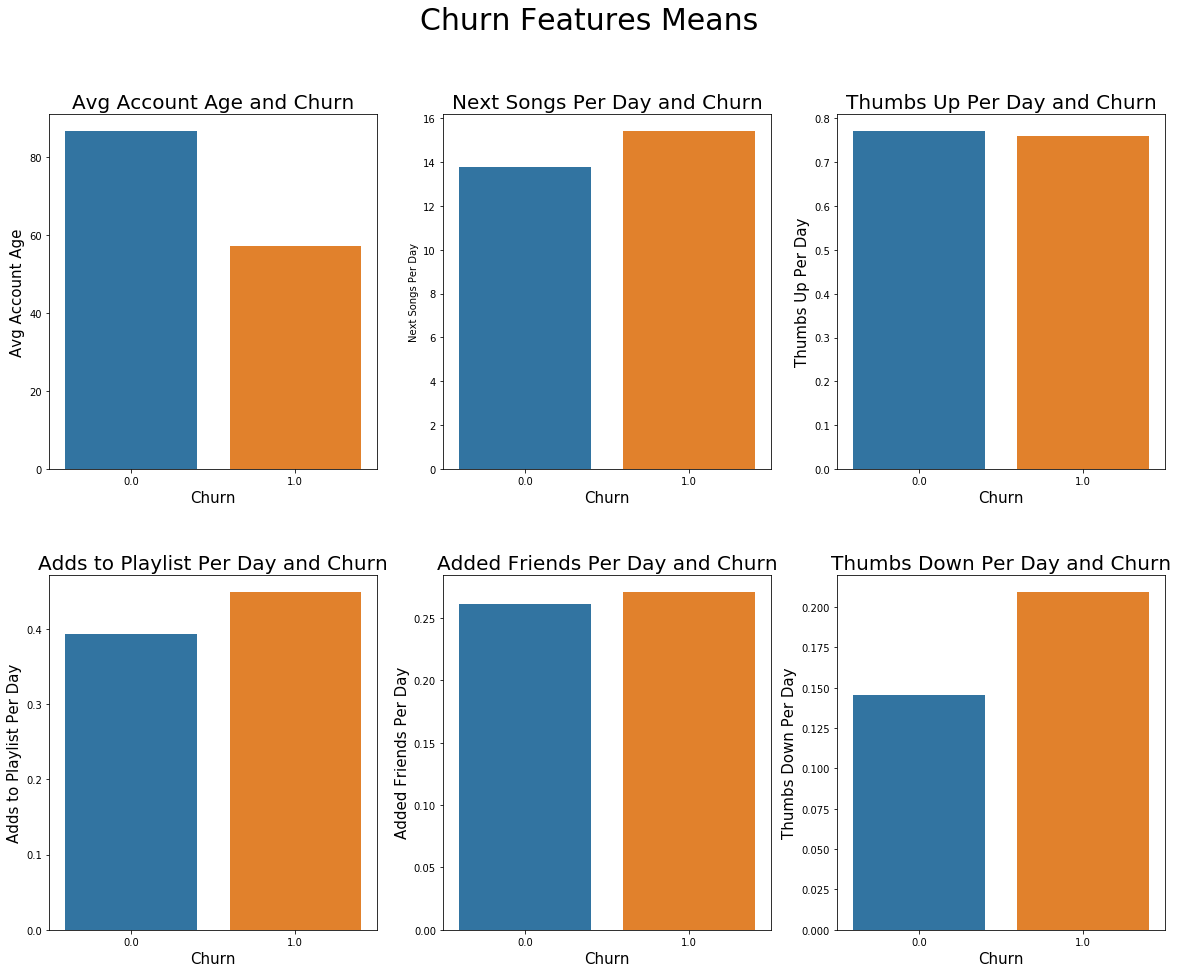

In [240]:
figure, axs = plt.subplots(nrows=2, ncols=3, figsize = (20, 15))
figure.suptitle('Churn Features Means', size=30);

plt.subplots_adjust(wspace=0.2, hspace=0.3)

sns.barplot(x="churn", y="accountAge", data=df_agg_viz, ax=axs[0][0])
axs[0][0].set_title('Avg Account Age and Churn', size=20)
axs[0][0].set_ylabel('Avg Account Age', size=15)
axs[0][0].set_xlabel('Churn', size=15)

sns.barplot(x="churn", y="nextSongPerDay", data=df_agg_viz, ax=axs[0][1])
axs[0][1].set_title('Next Songs Per Day and Churn', size=20)
axs[0][1].set_ylabel('Next Songs Per Day')
axs[0][1].set_xlabel('Churn', size=15)

sns.barplot(x="churn", y="thumbsUpPerDay", data=df_agg_viz, ax=axs[0][2])
axs[0][2].set_title('Thumbs Up Per Day and Churn', size=20)
axs[0][2].set_ylabel('Thumbs Up Per Day', size=15)
axs[0][2].set_xlabel('Churn', size=15)

sns.barplot(x="churn", y="addToPlaylistPerDay", data=df_agg_viz, ax=axs[1][0])
axs[1][0].set_title('Adds to Playlist Per Day and Churn', size=20)
axs[1][0].set_ylabel('Adds to Playlist Per Day', size=15)
axs[1][0].set_xlabel('Churn', size=15)

sns.barplot(x="churn", y="addFriendPerDay", data=df_agg_viz, ax=axs[1][1])
axs[1][1].set_title('Added Friends Per Day and Churn', size=20)
axs[1][1].set_ylabel('Added Friends Per Day', size=15)
axs[1][1].set_xlabel('Churn', size=15)

sns.barplot(x="churn", y="thumbsDownPerDay", data=df_agg_viz, ax=axs[1][2])
axs[1][2].set_title('Thumbs Down Per Day and Churn', size=20)
axs[1][2].set_ylabel('Thumbs Down Per Day', size=15)
axs[1][2].set_xlabel('Churn', size=15)

plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


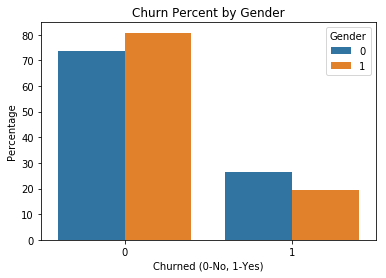

In [119]:
# visualize gender and level 
gender_pd = df_agg.groupby(["churn", "gender"]).count().toPandas()
gender_M = gender_pd[gender_pd['gender'] == '0']
gender_F = gender_pd[gender_pd['gender'] == '1']

## divide by male and femal counts
gender_M['percent'] = round(gender_M['count'].astype(int)/(89+32)*100, 2)
gender_F['percent'] = round(gender_F['count'].astype(int)/(84+20)*100, 2)

gender_pd = pd.concat([gender_M, gender_F])

ax = sns.barplot(x='churn', y='percent', hue='gender', data=gender_pd)
plt.xlabel('Churned (0-No, 1-Yes)')
plt.ylabel('Percentage')
plt.legend(title='Gender')
plt.title('Churn Percent by Gender')
plt.show()

### EDA churn findings 



Aggregate stats indicate that, in general, users who churned have: 
- Shorter account ages than users who didn't churn, suggesting that the longer a user has had an account, the less likely they are to churn.

- A slightly higher average for next songs per day, indicating that maybe churned users flip through more songs (and don't complete as many) as users who didn't churn. 

- A slightly lower average number of thumbs up per day, suggesting that users who churn are less engaged in this manner. 

- A slightly higher number of adds to playlists per day, indicating that perhaps churned users are a little more particular about their music tastes. 

- A marginally higher average number of friends added per day.

- A higher average number of thumbs down per day, indicating that churned users are more active in voicing negative opinions in this manner. 

The churn by gender barplot shows that males are slightly more likely to churn than females. 

Note, the averages for next songs per day, thumbs up per day, and added friends per day are marginally different and out sample size is quite small at 225 users, so we should definitely take these findings with a grain of salt. 


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [142]:
# create df for modeling 
df_agg2_cols = ['userId','accountAge', 'label', 'gender',
                'nextSongPerDay', 'thumbsUpPerDay', 'addToPlaylistPerDay',
                'addFriendPerDay','thumbsDownPerDay']
df_agg2 = df_agg.withColumn("label",df_agg.churn.cast("Int")) \
        .select(df_agg2_cols)

In [144]:
df_agg2.printSchema()

root
 |-- userId: string (nullable = true)
 |-- accountAge: double (nullable = false)
 |-- label: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- nextSongPerDay: double (nullable = true)
 |-- thumbsUpPerDay: double (nullable = true)
 |-- addToPlaylistPerDay: double (nullable = true)
 |-- addFriendPerDay: double (nullable = true)
 |-- thumbsDownPerDay: double (nullable = true)



In [145]:
# split train and test datasets
train, test = df_agg2.randomSplit([0.6, 0.4], seed=2)

In [168]:
# format variables 

# index categorical feature
stringIndexerGender = StringIndexer(inputCol="gender", outputCol="genderIndex") 
encoder = OneHotEncoderEstimator(inputCols=["genderIndex"], outputCols=["genderVec"])

# vector assembler - create vector for features
features = ['genderVec','accountAge', 'nextSongPerDay', 'thumbsUpPerDay', 'addToPlaylistPerDay',
            'addFriendPerDay', 'thumbsDownPerDay']
assembler = VectorAssembler(inputCols=features, outputCol="features")
# df_agg2_features = assembler.transform(df_agg2)

# # scale vectors
    # won't do this because have categorical and numeric features 
# scaler = StandardScaler(inputCol="features", outputCol="ScaledNumFeatures", withStd=True)




In [186]:
# models and pipelines 

# https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression
lr =  LogisticRegression()
lr_pipeline = Pipeline(stages = [stringIndexerGender, encoder, 
                                 assembler, lr])

# https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier
rf = RandomForestClassifier(numTrees=5, maxDepth=5, labelCol="label", 
                            featuresCol="features", seed=2)
rf_pipeline = Pipeline(stages = [stringIndexerGender, encoder, 
                                 assembler, rf])

# https://spark.apache.org/docs/latest/ml-classification-regression.html#gradient-boosted-tree-classifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", seed=2)

gbt_pipeline = Pipeline(stages = [stringIndexerGender, encoder, 
                                 assembler, gbt])

In [178]:
# initialize fscore dict
f_score_dict = {}

In [183]:
# eval metrics
# https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html

lr_model = lr_pipeline.fit(train)
lr_pred_train = lr_model.transform(train)
lr_pred_test = lr_model.transform(test)

# f1 score for train
predictionAndLabels = lr_pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
f_score_dict.update({'lr_train': metrics.fMeasure()})

# f1 score for test
predictionAndLabels = lr_pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
f_score_dict.update({'lr_test': metrics.fMeasure()})


In [187]:
rf_model = rf_pipeline.fit(train)
rf_pred_train = rf_model.transform(train)
rf_pred_test = rf_model.transform(test)

# f1 score for train
predictionAndLabels = rf_pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
f_score_dict.update({'rf_train': metrics.fMeasure()})

# f1 score for test
predictionAndLabels = rf_pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
f_score_dict.update({'rf_test': metrics.fMeasure()})


In [188]:
gbt_model = gbt_pipeline.fit(train)
gbt_pred_train = gbt_model.transform(train)
gbt_pred_test = gbt_model.transform(test)

# f1 score for train
predictionAndLabels = gbt_pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
f_score_dict.update({'gbt_train': metrics.fMeasure()})

# f1 score for test
predictionAndLabels = gbt_pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
f_score_dict.update({'gbt_test': metrics.fMeasure()})


In [189]:
# random forest seems to perform best on test data
# perform cross validation on to try to optimize model 

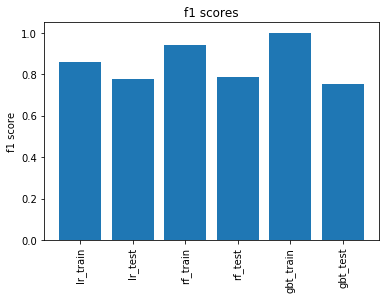

In [206]:
f_score_dict = {'lr_train': 0.8602941176470589,
 'lr_test': 0.7752808988764045,
 'rf_train': 0.9411764705882353,
 'rf_test': 0.7865168539325843,
 'gbt_train': 1.0,
 'gbt_test': 0.7528089887640449}

plt.bar(range(len(f_score_dict)), list(f_score_dict.values()), align='center')
plt.title('f1 scores')
plt.xticks(range(len(f_score_dict)), list(f_score_dict.keys()),
          rotation='vertical')
plt.ylabel('f1 score')
plt.show()

In [199]:
# random forest cross validation 
# https://spark.apache.org/docs/latest/ml-tuning.html
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees,[5, 10]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

crossval_rf = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

cv_mod_rf = crossval_rf.fit(train)

In [200]:
cv_rf_pred_train = cv_mod_rf.transform(train)
cv_rf_pred_test = cv_mod_rf.transform(test)

# f1 score for train
predictionAndLabels = cv_rf_pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
f_score_dict.update({'cv_rf_train': metrics.fMeasure()})

# f1 score for test
predictionAndLabels = cv_rf_pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
f_score_dict.update({'cv_rf_test': metrics.fMeasure()})


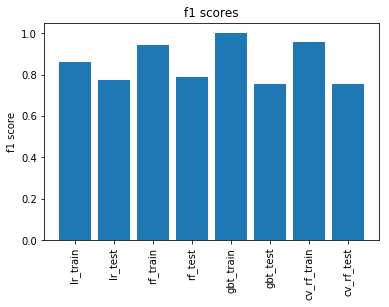

In [205]:
f_score_dict = {'lr_train': 0.8602941176470589,
 'lr_test': 0.7752808988764045,
 'rf_train': 0.9411764705882353,
 'rf_test': 0.7865168539325843,
 'gbt_train': 1.0,
 'gbt_test': 0.7528089887640449,
 'cv_rf_train': 0.9558823529411765,
 'cv_rf_test': 0.7528089887640449}

plt.bar(range(len(f_score_dict)), list(f_score_dict.values()), align='center')
plt.title('f1 scores')
plt.xticks(range(len(f_score_dict)), list(f_score_dict.keys()),
          rotation='vertical')
plt.ylabel('f1 score')
plt.show()

## Modeling findings
- We see that the random forest model performs the best with the initial parameters provided when compared to logistic regression and gradient boosted trees. To reduce processing time, I pursued cross validation with the random forest model to further optimize parameters.


#### Areas for future improvement: 
- Note, we are performing this analysis on a subset of the data, so data points when using userId as the unit of analysis is somewhat minimal with 225 observations. This shouldn't be a problem if we were to scale the script to the full dataset. 

- If we wanted to create more data points with this data, one option might be to create rolling averages for each user to predict whether or not they'll churn the next day. We could do this by looking at their activity the past week and past month. If activity during the past week is different in a predictable way, that might lend itself to predicting future churn. 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.